# FD001/FD004 베이스라인 모델 성능 비교

비시계열 및 시계열 모델을 활용한 NASA Turbofan 데이터셋(FD001, FD004)의 RUL 예측 베이스라인 성능 비교 노트북입니다.

- **비시계열 모델**: Linear Regression, XGBoost, RandomForest, KNN
- **시계열 모델**: LSTM (Sequence=30, 50), TCN
- **출력**: FD001/FD004 각각의 RMSE·MAE, (선택) 모델별 inference 시간

---

In [1]:
# 1. 필요 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# XGBoost
from xgboost import XGBRegressor

# TensorFlow/Keras (LSTM, TCN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# TCN (Keras TCN)
try:
    from tcn import TCN
except ImportError:
    TCN = None

# PyTorch (optional for TCN)
try:
    import torch
    import torch.nn as nn
except ImportError:
    torch = None

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 2. 데이터 불러오기 및 전처리
# 데이터 경로는 필요에 따라 수정하세요.
fd001_train = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
fd001_test  = pd.read_csv('../CMaps/Data/test_FD001_with_RUL.csv')
fd004_train = pd.read_csv('../CMaps/Data/train_FD004_with_RUL.csv')
fd004_test  = pd.read_csv('../CMaps/Data/test_FD004_with_RUL.csv')

# --- NaN 진단 및 처리 ---
# FD001/FD004 train/test 데이터의 NaN 개수 확인
print('FD001 train NaN 개수:', fd001_train.isna().sum().sum())
print('FD001 test NaN 개수:', fd001_test.isna().sum().sum())
print('FD004 train NaN 개수:', fd004_train.isna().sum().sum())
print('FD004 test NaN 개수:', fd004_test.isna().sum().sum())

# NaN 값이 있으면 평균값으로 대체 (또는 필요시 제거)
fd001_train = fd001_train.fillna(fd001_train.mean())
fd001_test  = fd001_test.fillna(fd001_test.mean())
fd004_train = fd004_train.fillna(fd004_train.mean())
fd004_test  = fd004_test.fillna(fd004_test.mean())
print('NaN 처리 후 FD001 train NaN 개수:', fd001_train.isna().sum().sum())
print('NaN 처리 후 FD001 test NaN 개수:', fd001_test.isna().sum().sum())
print('NaN 처리 후 FD004 train NaN 개수:', fd004_train.isna().sum().sum())
print('NaN 처리 후 FD004 test NaN 개수:', fd004_test.isna().sum().sum())
# ---

# 컬럼명 확인 및 feature/target 분리
def get_feature_target(df):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X = df[feature_cols].values
    y = df['RUL'].values
    return X, y

# 정규화 (StandardScaler)
scaler_fd001 = StandardScaler()
X_fd001_train, y_fd001_train = get_feature_target(fd001_train)
X_fd001_test,  y_fd001_test  = get_feature_target(fd001_test)
X_fd001_train = scaler_fd001.fit_transform(X_fd001_train)
X_fd001_test  = scaler_fd001.transform(X_fd001_test)

scaler_fd004 = StandardScaler()
X_fd004_train, y_fd004_train = get_feature_target(fd004_train)
X_fd004_test,  y_fd004_test  = get_feature_target(fd004_test)
X_fd004_train = scaler_fd004.fit_transform(X_fd004_train)
X_fd004_test  = scaler_fd004.transform(X_fd004_test)

print(f"FD001 train: {X_fd001_train.shape}, test: {X_fd001_test.shape}")
print(f"FD004 train: {X_fd004_train.shape}, test: {X_fd004_test.shape}")

FD001 train NaN 개수: 0
FD001 test NaN 개수: 12996
FD004 train NaN 개수: 0
FD004 test NaN 개수: 40966
NaN 처리 후 FD001 train NaN 개수: 0
NaN 처리 후 FD001 test NaN 개수: 0
NaN 처리 후 FD004 train NaN 개수: 0
NaN 처리 후 FD004 test NaN 개수: 0
FD001 train: (20631, 24), test: (13096, 24)
FD004 train: (61249, 24), test: (41214, 24)


In [3]:
def create_model(model_name, params, input_shape=None):
    if model_name == 'linear':
        return Ridge(alpha=params['alpha'], random_state=SEED)

    elif model_name == 'xgboost':
        return xgb.XGBRegressor(
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            random_state=SEED,
            n_jobs=-1
        )

    elif model_name == 'lightgbm':
        return lgb.LGBMRegressor(
            num_leaves=params['num_leaves'],
            max_depth=params['max_depth'],
            learning_rate=0.05,
            n_estimators=200,
            random_state=SEED,
            n_jobs=-1,
            verbose=-1
        )

    elif model_name == 'rf':
        return RandomForestRegressor(
            max_depth=params['max_depth'],
            n_estimators=params['n_estimators'],
            random_state=SEED,
            n_jobs=-1
        )

    elif model_name == 'lstm':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            return_sequences = (i < params['layers'] - 1)
            x = layers.LSTM(params['units'], return_sequences=return_sequences)(x)
            x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(1)(x)
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'gru':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            return_sequences = (i < params['layers'] - 1)
            x = layers.GRU(params['units'], return_sequences=return_sequences)(x)
            x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(1)(x)
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'cnn':
        inputs = Input(shape=input_shape)
        x = inputs

        for i in range(params['layers']):
            x = layers.Conv1D(params['filters'], params['kernel_size'],
                            activation='relu', padding='same')(x)
            x = layers.MaxPooling1D(2)(x)
            x = layers.Dropout(0.2)(x)

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

    elif model_name == 'tcn':
        inputs = Input(shape=input_shape)
        x = inputs

        for dilation in params['dilations']:
            x = layers.Conv1D(params['filters'], params['kernel_size'],
                            dilation_rate=dilation, activation='relu',
                            padding='causal')(x)
            x = layers.Dropout(0.2)(x)

        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(1)(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        return model

In [4]:
# 3. 비시계열 모델: Linear Regression
def run_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time

fd001_lr_rmse, fd001_lr_mae, fd001_lr_time = run_linear_regression(X_fd001_train, y_fd001_train, X_fd001_test, y_fd001_test)
fd004_lr_rmse, fd004_lr_mae, fd004_lr_time = run_linear_regression(X_fd004_train, y_fd004_train, X_fd004_test, y_fd004_test)

In [5]:
# 4. 비시계열 모델: XGBoost
def run_xgboost(X_train, y_train, X_test, y_test):
    model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time

fd001_xgb_rmse, fd001_xgb_mae, fd001_xgb_time = run_xgboost(X_fd001_train, y_fd001_train, X_fd001_test, y_fd001_test)
fd004_xgb_rmse, fd004_xgb_mae, fd004_xgb_time = run_xgboost(X_fd004_train, y_fd004_train, X_fd004_test, y_fd004_test)


In [6]:

# 5. 비시계열 모델: RandomForest
def run_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time

fd001_rf_rmse, fd001_rf_mae, fd001_rf_time = run_random_forest(X_fd001_train, y_fd001_train, X_fd001_test, y_fd001_test)
fd004_rf_rmse, fd004_rf_mae, fd004_rf_time = run_random_forest(X_fd004_train, y_fd004_train, X_fd004_test, y_fd004_test)


In [7]:

# 6. 비시계열 모델: KNN
def run_knn(X_train, y_train, X_test, y_test):
    model = KNeighborsRegressor(n_neighbors=5)
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time

fd001_knn_rmse, fd001_knn_mae, fd001_knn_time = run_knn(X_fd001_train, y_fd001_train, X_fd001_test, y_fd001_test)
fd004_knn_rmse, fd004_knn_mae, fd004_knn_time = run_knn(X_fd004_train, y_fd004_train, X_fd004_test, y_fd004_test)

In [8]:
# 7. 시계열 모델: LSTM (Sequence=30, 50)
def make_lstm_sequences(df, seq_len=30):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X, y = [], []
    for i in range(len(df) - seq_len + 1):
        X.append(df[feature_cols].iloc[i:i+seq_len].values)
        y.append(df['RUL'].iloc[i+seq_len-1])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def run_lstm(df_train, df_test, seq_len=30):
    X_train, y_train = make_lstm_sequences(df_train, seq_len)
    X_test, y_test = make_lstm_sequences(df_test, seq_len)
    model = build_lstm((seq_len, X_train.shape[2]))
    start = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    y_pred = model.predict(X_test).flatten()
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time

fd001_lstm30_rmse, fd001_lstm30_mae, fd001_lstm30_time = run_lstm(fd001_train, fd001_test, seq_len=30)
fd001_lstm50_rmse, fd001_lstm50_mae, fd001_lstm50_time = run_lstm(fd001_train, fd001_test, seq_len=50)
fd004_lstm30_rmse, fd004_lstm30_mae, fd004_lstm30_time = run_lstm(fd004_train, fd004_test, seq_len=30)
fd004_lstm50_rmse, fd004_lstm50_mae, fd004_lstm50_time = run_lstm(fd004_train, fd004_test, seq_len=50)


1287/1287 [==============================] - 3s 2ms/step


In [9]:

# 8. 시계열 모델: TCN (Keras TCN)
def build_tcn(input_shape):
    if TCN is None:
        raise ImportError('Keras TCN 패키지가 설치되어 있어야 합니다.')
    model = keras.Sequential([
        TCN(input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def run_tcn(df_train, df_test, seq_len=30):
    X_train, y_train = make_lstm_sequences(df_train, seq_len)
    X_test, y_test = make_lstm_sequences(df_test, seq_len)
    model = build_tcn((seq_len, X_train.shape[2]))
    start = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    y_pred = model.predict(X_test).flatten()
    inference_time = time.time() - start
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae, inference_time


In [10]:

# TCN 실행 예시 (설치된 경우만)
if TCN is not None:
    fd001_tcn_rmse, fd001_tcn_mae, fd001_tcn_time = run_tcn(fd001_train, fd001_test, seq_len=30)
    fd004_tcn_rmse, fd004_tcn_mae, fd004_tcn_time = run_tcn(fd004_train, fd004_test, seq_len=30)
else:
    fd001_tcn_rmse = fd001_tcn_mae = fd001_tcn_time = None
    fd004_tcn_rmse = fd004_tcn_mae = fd004_tcn_time = None

1288/1288 [==============================] - 5s 4ms/step


In [11]:
# 9. 모델별 예측 및 성능 평가 결과 정리
results = [
    ['LinearRegression', fd001_lr_rmse, fd001_lr_mae, fd001_lr_time, fd004_lr_rmse, fd004_lr_mae, fd004_lr_time],
    ['XGBoost', fd001_xgb_rmse, fd001_xgb_mae, fd001_xgb_time, fd004_xgb_rmse, fd004_xgb_mae, fd004_xgb_time],
    ['RandomForest', fd001_rf_rmse, fd001_rf_mae, fd001_rf_time, fd004_rf_rmse, fd004_rf_mae, fd004_rf_time],
    ['KNN', fd001_knn_rmse, fd001_knn_mae, fd001_knn_time, fd004_knn_rmse, fd004_knn_mae, fd004_knn_time],
    ['LSTM-30', fd001_lstm30_rmse, fd001_lstm30_mae, fd001_lstm30_time, fd004_lstm30_rmse, fd004_lstm30_mae, fd004_lstm30_time],
    ['LSTM-50', fd001_lstm50_rmse, fd001_lstm50_mae, fd001_lstm50_time, fd004_lstm50_rmse, fd004_lstm50_mae, fd004_lstm50_time],
    ['TCN', fd001_tcn_rmse, fd001_tcn_mae, fd001_tcn_time, fd004_tcn_rmse, fd004_tcn_mae, fd004_tcn_time]
    ]

columns = ['Model', 'FD001_RMSE', 'FD001_MAE', 'FD001_Time', 'FD004_RMSE', 'FD004_MAE', 'FD004_Time']
results_df = pd.DataFrame(results, columns=columns)



In [12]:
# 10. Baseline 결과 테이블 출력
print('모델별 FD001/FD004 성능 (RMSE, MAE, Inference Time)')
display(results_df)

모델별 FD001/FD004 성능 (RMSE, MAE, Inference Time)


,Model,FD001_RMSE,FD001_MAE,FD001_Time,FD004_RMSE,FD004_MAE,FD004_Time
0,LinearRegression,68.329347,62.108483,0.039979,89.947721,81.251204,0.041046
1,XGBoost,76.507067,68.753340,0.267806,99.966615,87.530920,0.177743
2,RandomForest,75.504846,69.010891,12.632252,100.885380,88.531534,51.383777
3,KNN,74.969044,66.980843,0.430218,100.859348,87.237100,1.931982
4,LSTM-30,32.495765,32.357515,29.895758,46.440384,46.328628,75.921719
5,LSTM-50,32.153777,32.015565,41.519177,46.779176,46.667809,108.226100
6,TCN,41.163075,40.606175,51.064775,68.674166,67.722843,162.122791


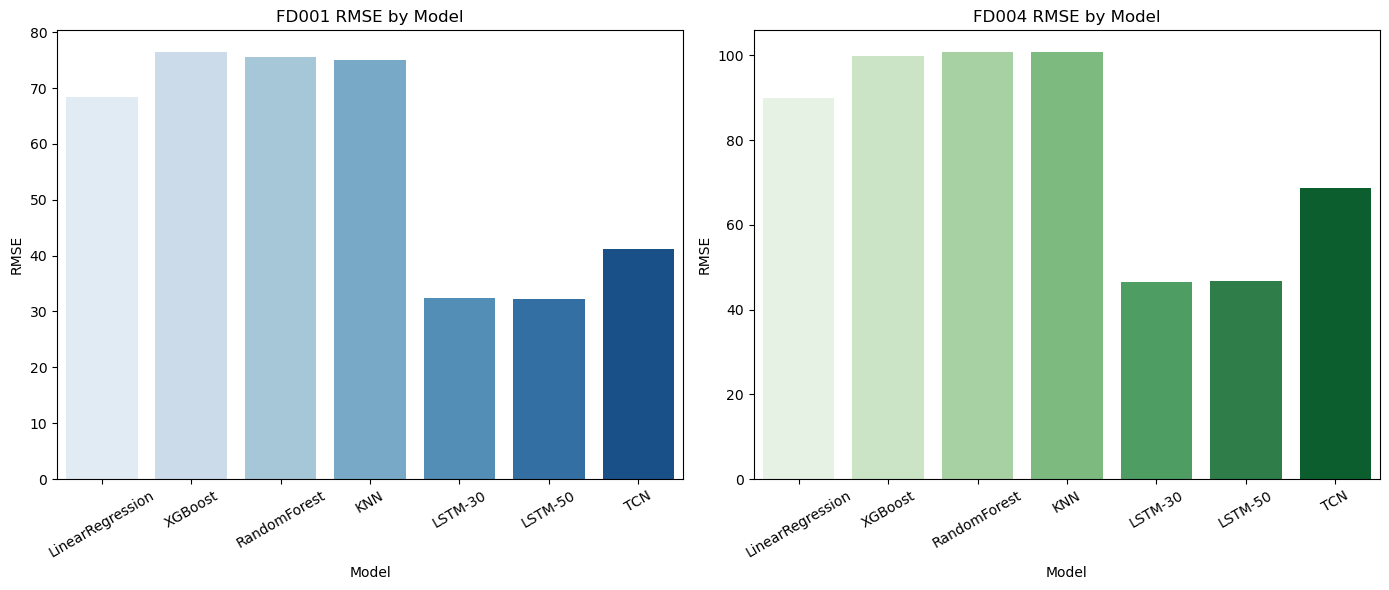

In [13]:
# 11. 모델별 성능 시각화 (Bar Chart)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='Model', y='FD001_RMSE', data=results_df, ax=axes[0], palette='Blues')
axes[0].set_title('FD001 RMSE by Model')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=30)

sns.barplot(x='Model', y='FD004_RMSE', data=results_df, ax=axes[1], palette='Greens')
axes[1].set_title('FD004 RMSE by Model')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [16]:
# 모델 저장 (models/ 폴더)
import joblib
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(LinearRegression(), '../models/linear_regression.pkl')
joblib.dump(RandomForestRegressor(), '../models/random_forest.pkl')
joblib.dump(KNeighborsRegressor(), '../models/knn.pkl')
joblib.dump(XGBRegressor(), '../models/xgboost.pkl')
# LSTM, TCN 등 딥러닝 모델은 아래처럼 저장
# 예시: keras 모델 저장

['../models/xgboost.pkl']